# Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as T
import torchvision.ops as ops

from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

from ignite.engine.events import Events
from ignite.metrics import Accuracy, RunningAverage
from ignite.engine import create_supervised_trainer
from ignite.engine import create_supervised_evaluator
from ignite.contrib.handlers.tqdm_logger import ProgressBar

A couple of libraries that we need aren't preinstalled on Colab.

In [2]:
# %%capture
# !pip install pynvml
# !pip install pytorch-ignite

# Data

For this assignment, we will be working with the **[Linnaeus 5](http://chaladze.com/l5/)** dataset. This dataset comes in several variations, each with different image sizes. We will download the 128x128 variant:

In [3]:
# !wget -c "http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar"

We need to extract this file:

In [4]:
# !unrar x "Linnaeus 5 128X128.rar" -idq

which creates "Linnaeus 5 128X128.rar" with two subfolders: `train` and `test`. We won't be needing a validation set, so loading these two would suffice.

The dataset is not that large and ViTs are extremely data-hungry. Therefore, it's crucial that we use a technique like Transfer Learning. Otherwise, the model is unlikely to learn anything. Assuming that we will use a model that has been trained on ImageNet, we can use the following means and stds to normalize our inputs:

In [5]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

Putting it all together:

In [6]:
train_set = datasets.ImageFolder('Linnaeus 5 128X128/train', transform=transform)
test_set = datasets.ImageFolder('Linnaeus 5 128X128/test', transform=transform)

# Modeling

We highly recommend checking out the [original paper](https://arxiv.org/pdf/2010.11929.pdf) and [Google's implementation](https://github.com/google-research/vision_transformer) to learn more about this model.

## Architecture

The model is quite simple to implement. You only need a `Conv2D` layer to break down the image into patches and project each individually, followed by a transformer encoder and a prediction head. Let's begin with the encoder. We have to first implement an encoder layer. 

The block isn't that different to a conventional encoder block in a Transformer. We only need to add one element to the outputs of its `forward()` method, and that is the attention weights. We recommend using [`nn.MultiheadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) which will provide you with the weights quite easily.

**Do not change the name of the attributes.**

In [7]:
class EncoderBlock(nn.Module):

    def __init__(self, num_heads, d_model, d_feedforward, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        # Fill in the missing modules.
        self.ln_1 = nn.LayerNorm(d_model)
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.ln_2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_feedforward, d_model),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        # Your code goes here.
        # You need to output the encoded values and the attention weights.
        x = self.ln_1(inputs)
        x, aw = self.self_attention(x, x, x, need_weights=True)
        x = self.dropout(x)
        x = x + inputs
        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y, aw

Next, we'll use this layer to build up the encoder network. Note that unlike conventional transformers, ViTs work better with learned positional encodings rather than generated ones. That's why we have introduced the `pos_embedding` parameter which will be optimized just like any other weight in the network.

In [8]:
class Encoder(nn.Module):

    def __init__(self, seq_length, num_layers, num_heads, d_model, d_feedforward, dropout=0.0):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, d_model).normal_(std=0.02))
        # Fill in the missing modules.
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = EncoderBlock(num_heads, d_model, d_feedforward, dropout)
            self.layers.append(layer)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, inputs):
        # Your code goes here.
        # You need to output the encoded values and a list of attention weights.
        ls_aw = []
        x = inputs + self.pos_embedding
        x = self.dropout(x)
        
        for layer in self.layers:
            x, aw = layer(x)
            ls_aw.append(aw)
        
        x = self.ln(x) # MAY
        return x, ls_aw

We're all set! Let's now build the ViT itself. We'll need another learnable parameter: the `cls` token.

In [9]:
class ViT(nn.Module):

    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads, d_model, d_feedforward, dropout=0.0):
        super().__init__()
        self.patch_size = patch_size
        seq_length = (image_size // patch_size) ** 2
        # Fill in the missing modules.
        self.conv_proj = nn.Conv2d(3, d_model, patch_size,patch_size)
        self.encoder = Encoder(seq_length+1, num_layers, num_heads, d_model, d_feedforward, dropout)
        self.head = nn.Linear(d_model, num_classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.seq_length = seq_length + 1

    def process_input(self, x):
        x = self.conv_proj(x)
        x = x.flatten(2, 3)
        x = x.permute(0, 2, 1)
        return x

    def forward(self, x, need_weights=False):
        # Your code goes here.
        # You need to output the encoded values and a list of attention weights.
        x = self.process_input(x) 
        cls_batched = self.class_token.expand(x.size(0), -1, -1)
        x = torch.cat([cls_batched, x], dim = 1)
        x, aw = self.encoder(x)
        x = self.head(x[:, 0])
        return (x, aw) if need_weights else x

Let's now instantiate the model. The `B/32` variant is a suitable architecture for our dataset:

In [10]:
network = ViT(
    image_size=128,
    patch_size=32,
    num_classes=5,
    num_layers=12,
    num_heads=12,
    d_model=768,
    d_feedforward=3072,
)

## Transfer Learning

Download the ImageNet weights from [here](https://drive.google.com/file/d/1P5iEZgLueotpOYVsRkeMxjVWf6Z0zckr/view?usp=share_link) and load them into the model:

In [11]:
# !gdown "1P5iEZgLueotpOYVsRkeMxjVWf6Z0zckr"\

In [12]:
state_dict = torch.load('state_dict.pt')
network.load_state_dict(state_dict)

<All keys matched successfully>

## Training

We will use Torch Ignite to expedite the process. Since you have already learned about this model, there isn't much for you to do here!

In [13]:
batch_size = 16
learning_rate = 2e-4

In [14]:
train_loader = data.DataLoader(train_set, batch_size, shuffle=True)
eval_loader = data.DataLoader(train_set, batch_size, shuffle=False)

In [15]:
device = torch.device('cuda')
network = network.to(device)

In [16]:
# Fill in the missing modules.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(network.parameters(), lr=learning_rate)

In [17]:
trainer = create_supervised_trainer(network, optimizer, criterion, device)
evaluator = create_supervised_evaluator(network, metrics={'accuracy': Accuracy()}, device=device)

In [18]:
@trainer.on(Events.EPOCH_COMPLETED)
def evaluate(engine):
    evaluator.run(eval_loader)
    print(f'accuracy: {evaluator.state.metrics["accuracy"]:.2f}')

In [19]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')
ProgressBar().attach(trainer, ['loss'])

/home/erfan/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Luckily, we don't need to train for too long. With just one epoch:

In [20]:
# 3 epochs are enough to get the label right
trainer.run(train_loader, max_epochs=3)

[1/375]   0%|           [00:00<?]

accuracy: 0.48


[1/375]   0%|           [00:00<?]

accuracy: 0.58


[1/375]   0%|           [00:00<?]

accuracy: 0.63


State:
	iteration: 1125
	epoch: 3
	epoch_length: 375
	max_epochs: 3
	output: 0.6635962724685669
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

## Self-Attention

We can now inspect the attention values in the model to verify exactly what the model is looking at when making a prediction. This is extensively studied in Section 4.5 in the [original paper](https://arxiv.org/pdf/2010.11929.pdf), but for this assignment, we are going to focus on a simpler version of this study.

As you know, we concatenate a learned `cls` token to the extracted image patches, and take out its corresponding token from the encoder network to then predict the category of the image. With this design, the self-attention weights in each layer of the model can tell us which patches were the most crucial ones in making that prediction.

Let's pick a random image and inspect the attention weights.

In [21]:
filepath = 'Linnaeus 5 128X128/test/bird/40_128.jpg'

In [22]:
im = Image.open(filepath)
im.show()

In [23]:
sample = transform(im)
batch = sample.unsqueeze(0)
batch = batch.to(device)

In [24]:
logits, weights = network(batch, need_weights=True)

kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found


We can quickly check that the model has made the right prediction:

In [25]:
# Pass the logits through sigmoid and get the index of the largest score.
sig = nn.Sigmoid()
preds = sig(logits)
pred = torch.argmax(preds)
print(pred)

tensor(1, device='cuda:0')


To see what this index represents, we have to check the dataset:

In [26]:
train_set.class_to_idx

{'berry': 0, 'bird': 1, 'dog': 2, 'flower': 3, 'other': 4}

That seems to be correct. We should now the weights. The model's output, `weights`, is a list containing 12 tensors that are all shaped as `(1, 17, 17)`. As previously discussed, we'll solely focus on the final output. Let's extract that:

In [82]:
w = weights[-1]

and take a look at the weights associated with the `cls` token, which is:

In [83]:
# Extract the last 16 elements from the first column and reshape it as 4x4.
w = w[0, 1:, 6].reshape((4,4))

and finally, we can overlay the two. To do so, they need to be of the same size. Scipy can help with that:

In [84]:
w = zoom(w.cpu().detach().numpy(), zoom=32, mode='nearest')

Finally:

My result

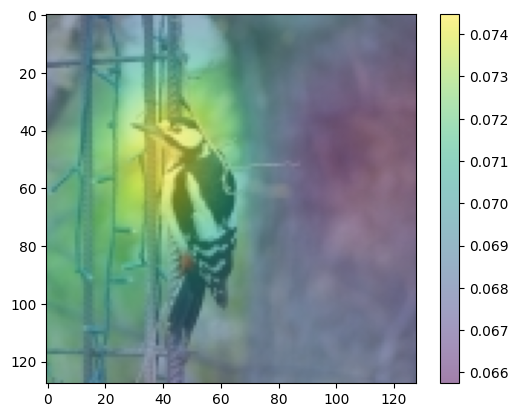

In [85]:
plt.imshow(im)
plt.imshow(w, cmap='viridis', alpha=0.5)
plt.colorbar()

Notebook Sample Result

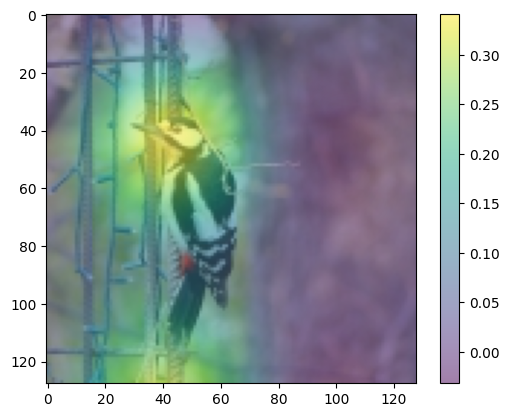

In [ ]:
# plt.imshow(im)
# plt.imshow(w, cmap='viridis', alpha=0.5)
# plt.colorbar()

The model is clearly focusing on the bird. Can you imagine how we can use this property to create weakly supervised solutions?

Answer: we can use this attention weight that we know is capable of finding birds and run it over the parts of dataset where we do not have any labels. In those case if it did find any bird we can classify as bird, or even better we can use the attention weights of each of the classes and run them on each unlabeld image and then using softmax or sigmoid determine the label.